In [ ]:
import numpy as np
import math
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from skimage.exposure import rescale_intensity
from PIL import Image 
import matplotlib.pylab as plt

# Input Image

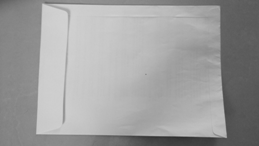

In [ ]:
#url = "https://iiif.lib.ncsu.edu/iiif/0052574/full/800,/0/default.jpg"
url = "https://i.stack.imgur.com/jA36n.png/i.stack.imgur.com/HJ3MW.png"
image = io.imread(url)
image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(image_2, cv.COLOR_RGB2GRAY)
cv2_imshow(image_2)

# **1.Noise Reduciton**

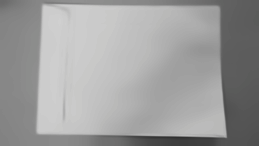

In [ ]:
image_noise = cv.fastNlMeansDenoisingColored(image_2, None, 10, 10, 7, 15)
cv2_imshow(image_noise)

**Gaussian noise reduction**

In [ ]:
def noisy(noise_typ,image,var):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      noisy = rescale_intensity(noisy, in_range=(0, 255))
      noisy = (noisy*255).astype("uint8")
      return noisy


image_noise = noisy("gauss", image_2, 500)
image_noise_2 = noisy("gauss", image_2, 1000)
image_noise_2 = cv.cvtColor(src=image_noise_2, code=cv.COLOR_BGR2GRAY)
image_noise = cv.cvtColor(src=image_noise, code=cv.COLOR_BGR2GRAY)

In [ ]:
def normalize(image):
  image = np.where(image<0, 0, image) 
  cv.normalize(image, image, 0, 255, cv.NORM_MINMAX)
  return image

In [ ]:
def convolve2D(image, kernel, padding=0, strides=1, correlation=0, normalize = 0):
    #Correlation
    if correlation == 0:
      kernel = np.flipud(np.fliplr(kernel))
    
    image = np.array(image)

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                        
                except:
                    break
    if normalize:
      cv.normalize(output, output, 0, 255, cv.NORM_MINMAX)
    return output

In [ ]:
def gaussian_filter(shape, sigma):
  gaussian = np.zeros(shape)
  for i in range(shape[0]):
    for j in range(shape[1]):
      gaussian[i][j] = (math.exp((-((shape[0]-i)**2)+((shape[0]-j)**2))/(2*(sigma**2))))/((2*(sigma**2)*np.pi))
  return gaussian
gaussian = gaussian_filter([7,7], 2.6)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


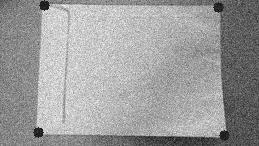

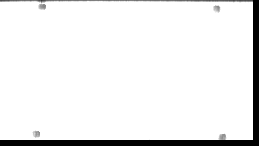

In [ ]:
image_gaussian = convolve2D(image_noise,gaussian,padding = 3)
image_gaussian_normalized = np.zeros(image_gaussian.shape)
cv.normalize(image_gaussian, image_gaussian_normalized, 0, 255, cv.NORM_MINMAX)

cv2_imshow(image_noise)
cv2_imshow(image_gaussian)

**Laplacian**

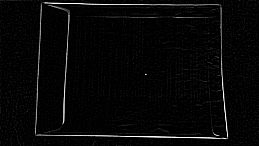

In [ ]:
image_lap = cv.Laplacian(image_2,cv.CV_64F,ksize=3)
cv2_imshow(image_lap)

# **2.Edge Detector**

**Canny**

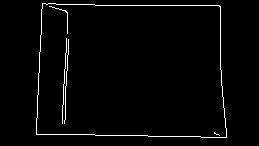

In [ ]:
canny_result = cv.Canny(np.uint8(image_2),100,200)
cv2_imshow(canny_result)

**Laplacian**

**a)using cv inbuilt**

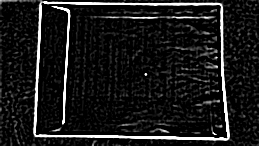

In [ ]:
# remove noise
img_blur = cv.GaussianBlur(gray,(3,3),0)

laplacian = cv.Laplacian(img_blur,cv.CV_64F,ksize=5)
cv2_imshow(laplacian)

**b)using functions**

laplacian over gaussian filter formula

In [ ]:
def l_o_g(x, y, sigma):
    # Formatted this way for readability
    nom = ( (y**2)+(x**2)-2*(sigma**2) )
    denom = ( (2*math.pi*(sigma**6) ))
    expo = math.exp( -((x**2)+(y**2))/(2*(sigma**2)) )
    return nom*expo/denom


creating filter image

In [ ]:
def create_log(sigma, size = 7):
    w = math.ceil(float(size)*float(sigma))

    if(w%2 == 0):
        w = w + 1

    l_o_g_mask = []

    w_range = int(math.floor(w/2))
    print("Going from " + str(-w_range) + " to " + str(w_range))
    for i in range(-w_range, w_range):
        for j in range(-w_range, w_range):
            l_o_g_mask.append(l_o_g(i,j,sigma))
    l_o_g_mask = np.array(l_o_g_mask)
    l_o_g_mask = l_o_g_mask.reshape(w,w)
    return l_o_g_mask


Convolving the filter over the original image

In [ ]:
def convolve(image, mask):
    width = image.shape[1]
    height = image.shape[0]
    w_range = int(math.floor(mask.shape[0]/2))

    res_image = np.zeros((height, width))

    # Iterate over every pixel that can be covered by the mask
    for i in range(w_range,width-w_range):
        for j in range(w_range,height-w_range):
            # Then convolute with the mask 
            for k in range(-w_range,w_range):
                for h in range(-w_range,w_range):
                    res_image[j, i] += mask[w_range+h,w_range+k]*image[j+h,i+k]
    return res_image


Checking the zeros to mark the edges

In [ ]:
def z_c_test(l_o_g_image):
    z_c_image = np.zeros(l_o_g_image.shape)

    # Check the sign (negative or positive) of all the pixels around each pixel
    for i in range(1,l_o_g_image.shape[0]-1):
        for j in range(1,l_o_g_image.shape[1]-1):
            neg_count = 0
            pos_count = 0
            for a in range(-1, 1):
                for b in range(-1,1):
                    if(a != 0 and b != 0):
                        if(l_o_g_image[i+a,j+b] < 0):
                            neg_count += 1
                        elif(l_o_g_image[i+a,j+b] > 0):
                            pos_count += 1

            # If all the signs around the pixel are the same and they're not all zero, then it's not a zero crossing and not an edge. 
            # Otherwise, copy it to the edge map.
            z_c = ( (neg_count > 0) and (pos_count > 0) )
            if(z_c):
                z_c_image[i,j] = 1

    return z_c_image


Run log function

In [ ]:
def run_l_o_g(bin_image, sigma_val, size_val):
    # Create the l_o_g mask
    print("creating mask")
    l_o_g_mask = create_log(sigma_val, size_val)

    # Smooth the image by convolving with the LoG mask
    print("smoothing")
    l_o_g_image = convolve(bin_image, l_o_g_mask)

    # Display the smoothed imgage
    blurred = fig.add_subplot(1,4,2)
    blurred.imshow(l_o_g_image, cmap=cm.gray)

    # Find the zero crossings
    print("finding zero crossings")
    z_c_image = z_c_test(l_o_g_image)
    print(z_c_image)

    #Display the zero crossings
    edges = fig.add_subplot(1,4,3)
    edges.imshow(z_c_image, cmap=cm.gray)
    pylab.show()


In [ ]:
run_l_o_g(gray,5,5)

creating mask
Going from -12 to 12


ValueError: ignored

# **3.Contours**

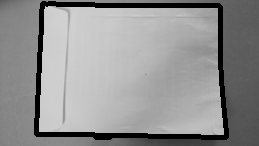

In [ ]:
image_4 = image
edged = cv.Canny(gray, 30, 200)
contours, hierarchy = cv.findContours(edged,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
cv.drawContours(image_4, contours, -1, (0, 0, 255), 3)
cv2_imshow(image_4)

In [ ]:
# corners = cv.goodFeaturesToTrack(gray, 27, 0.01, 10)
# corners = np.int0(corners)
# print(corners)

# **4.Corner points**

44.0 5.0
224.0 135.0
38.0 132.0
218.0 7.0


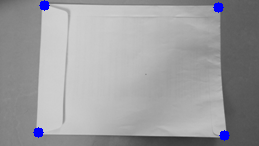

In [ ]:
image_3 = image_2
corners = cv.goodFeaturesToTrack(canny_result,4,0.5,50)

for corner in corners:
    x,y = corner.ravel()
    cv.circle(image_3,(x,y),5,(255,0,0),-1)
    print(x,y)
cv2_imshow(image_3)

# **5.Perspective transformation**

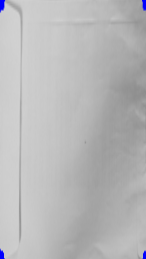

In [ ]:
a,b,c = image_2.shape
pts1 = np.float32([[44,5],[224,135],[38,132],[218,7]])
pts2 = np.float32([[0,0],[a,b],[0,b],[a,0]])
matrix = cv.getPerspectiveTransform(pts1,pts2)
result = cv.warpPerspective(image_2, matrix, (a,b))
#print(a,b,c)
cv2_imshow(result)

# **6.Histogram Equalization**

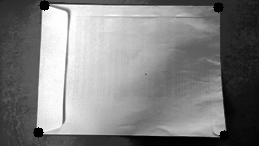

In [ ]:
img_grey = cv.cvtColor(image_2,cv.COLOR_BGR2GRAY)
image_cv_eq = cv.equalizeHist(img_grey)
img_eq = cv.cvtColor(image_cv_eq,cv.COLOR_GRAY2RGB)
cv2_imshow(img_eq)
#cv2_imshow(image_cv_eq)

# **7.Histogram Sliding**



In [ ]:
x = float(input("Enter the value of brightness: "))

Enter the value of brightness: 10


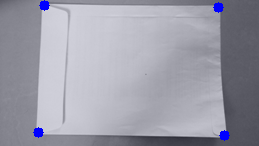

In [ ]:
image_shifted = cv.add(image_2, x)
image_shifted = np.clip(image_shifted, 0, 255)
cv2_imshow(image_shifted)

# **8.Rotation and Resizing**

**Rotation**

In [ ]:
rot_angle = float(input("Enter the angle by which image has to be rotated: "))
scale = float(input("Enter the value by which image has to scaled: "))

Enter the angle by which image has to be rotated: 45
Enter the value by which image has to scaled: 0.4


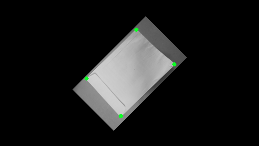

In [ ]:
(rows, cols) = image_2.shape[:2]
M = cv.getRotationMatrix2D((cols / 2, rows / 2), rot_angle, scale)
res = cv.warpAffine(image_2, M, (cols, rows))
cv2_imshow(res)

**Resizing**

In [ ]:
s_w = float(input("Enter the scale value to which width has to be resized: "))
s_h = float(input("Enter the scale value to which height has to be resized: "))

Enter the scale value to which width has to be resized: 2
Enter the scale value to which height has to be resized: 2


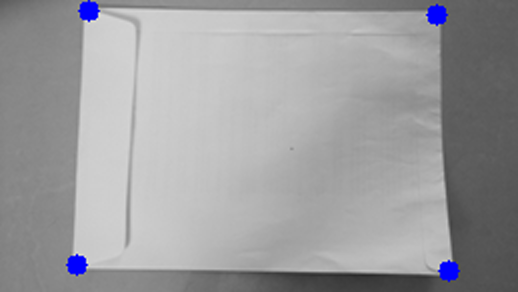

In [ ]:
(height, width) = image_2.shape[:2]
 
res = cv.resize(image_2, (int(width*s_w), int(height*s_h)), interpolation = cv.INTER_CUBIC)
cv2_imshow(res)